In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['font.size'] = 18

## Working with Dask on Cheyenne

### Here I'll make a guide to using dask on Cheyenne, the way I use it at least, and some tools to make it more friendly

### Dask installation
I'll start with a fresh conda environment, since that is most likely to avoid any issues. I'll create a conda environment with the basic packages needed:
> `conda create -n myenv -c conda-forge numpy scipy matplotlib xarray dask dask-jobqueue cartopy netcdf4`  
> `conda activate myenv`

### dask_labextension
Next, I'll make use of the really nice dask-labextension tool for Jupyter Lab. This lets you monitor the progress of your computation from within Jupyter. It takes a bit of set up, but you only need to do it once. I'll walk through it here

dask_labextension requires nodejs. By default, conda installs a version that is too old. But, you can make it install the right one by typing:
>```conda install -c conda-forge nodejs --repodata-fn=repodata.json```

You can then install dask_labextension by typing:
>```conda install -c conda-forge dask-labextension```

If your version of Jupyterlab is less than 3.0.0, you'll need to do the following. If it's at least 3.0.0, ignore this step
>```jupyter labextension install dask-labextension```  
>```jupyter serverextension enable dask_labextension```  

Note the first command has a hypen in dask-labextension, while the second uses an underscore.

Finally, we need to edit one config file to allow dask dashboard to be accessible through the same ssh tunnell as JupyterLab
This is achieved by editing the file `~/.config/dask/distributed.yaml`. Find the following section:
```

#   ###################  
#   # Bokeh dashboard #  
#   ###################  

#   dashboard:
#     link: "http://{host}:{port}/status"
#     export-tool: False

```
then uncomment and edit the second to last line to make the section read:
```

#   ###################  
#   # Bokeh dashboard #  
#   ###################  

#   dashboard:
      link: "/proxy/{port}/status"
#     export-tool: False

```

### Using dask-labextension in JupyterLab

Now that it's installed, dask-labextension will appear as a button in the vertical toolbar on the far left of JupyterLab.
If you click on it, it will pull up a pane like this:

<img src="dask_pane.png" width ="250" >

### Starting a basic Dask cluster on Casper

To start a dask cluster with 10 cores on Casper, do the following (obviously substitute for your own project code):

In [2]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(project='UWAS0064')
cluster.scale(10)

from dask.distributed import Client
client = Client(cluster)
client

/glade/u/home/apauling/miniconda3/envs/isotope/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41130 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://10.12.205.30:42883 Dashboard: http://10.12.205.30:41130/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Notes for the Atmos machines

The atmos machines use the PBS scheduler rather than Slurm, which is used by Casper.

To do the above on an atmos machine, just replace `SLURMCluster` with `PBSCluster`, and leave out the project code

You can adjust the number of CPUs by changing the number in the `cluster.scale()` command.

Then, in the search bar at the top of the dask labextension pane, enter:
```
http://localhost:8888/proxy/8787/status
```
Note, that 8787 is the default port that dask will try to launch the cluster on. If it is occupied by another user, it will use a different number. Simply replace 8787 by the number before `/status` in the url next to **Dashboard** in the output of the client above.

Once you enter the address, the buttons that were previously grey should turn orange.

You can then open various monitoring panes from the orange buttons. The most useful (to me at least) are the TASK STREAM, PROGRESS and MEMORY (WORKER) tabs

### Example usage: GMST from the piControl run of CESM2

Here I'll compute the global mean surface temperature from the pre-industrial control run of CESM2. First I'll use `glob` to get a list of files to open

In [3]:
from glob import glob

ddir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/latest/'
dfiles = sorted(glob(ddir + '*.nc'))  # use sorted to make sure the files are in order for concatenation
dfiles

['/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc',
 '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CESM2_piControl_r1i1p1f1_gn_010001-019912.nc',
 '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CESM2_piControl_r1i1p1f1_gn_020001-029912.nc',
 '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CESM2_piControl_r1i1p1f1_gn_030001-039912.nc',
 '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CESM2_piControl_r1i1p1f1_gn_040001-049912.nc',
 '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CESM2_piControl_r1i1p1f1_gn_050001-059912.nc',
 '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CESM2_piControl_r1i1p1f1_gn_060001-069912.nc',
 '/gla

We can then pass this list to `open_mfdataset` and specify that we want to combine the files along a coordinate dimension (in this case, time) and tell it that we want to open the files in parallel using our dask cluster

In [4]:
mfds = xr.open_mfdataset(dfiles, combine='by_coords', parallel=True)
mfds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 14400)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 0001-01-15 12:00:00 ... 1200-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(1188, 192, 288), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(1188, 2), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float32 dask.array<chunksize=(1188, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float32 dask.array<chunksize=(1188, 288, 2), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                3
    cesm_casename:          b.e21.B1850.f09_g17.CMIP6-piControl.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-20T21:54:11Z
    data_specs_version:     01.00.29
    experiment:             pre-industrial control
    experiment_id:          piControl
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.p...
    grid:                   native 0.9x1.25 finite volume grid (192x288 latxlon)
    grid_label:             gn
    initialization_index:   1
    institution:            National Center for Atmospheric Research, Climate...
    institution_id:         NCAR
    license:                CMIP6 model data produced by <The National Center...
    mip_era:                CMIP6
    model_doi_url:          https://doi.org/10.5065/D67H1H0V
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl-spinup
    parent_mip_era:         CMIP6
    parent_source_id:       CESM2
    parent_time_units:      days since 0001-01-01 00:00:00
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    source_id:              CESM2
    source_type:            AOGCM BGC AER
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/613911cb-8d9b-44a2-9664-2eee8f522acb
    variable_id:            tas
    variant_info:           CMIP6 CESM2 piControl experiment with CAM6, inter...
    variant_label:          r1i1p1f1
    branch_time_in_parent:  48545.0
    branch_time_in_child:   0.0
    branch_method:          standard

### Compute the area-weighted GMST

We can then make use of the recent addition of the `.weighted` method to compute an area-weighted average of the temperature field in parallel using our dask cluster. You should see the monitoring panes show the tasks and progress as it computes this.

In [5]:
t = mfds['tas']
tmean = t.weighted(np.cos(np.deg2rad(t.lat))).mean(('lat', 'lon')).compute()
tmean

<xarray.DataArray (time: 14400)>
array([285.11388909, 285.06396818, 285.79976646, ..., 287.43098047,
       286.48688263, 285.5389372 ])
Coordinates:
  * time     (time) object 0001-01-15 12:00:00 ... 1200-12-15 12:00:00

### We can then do some plots for fun

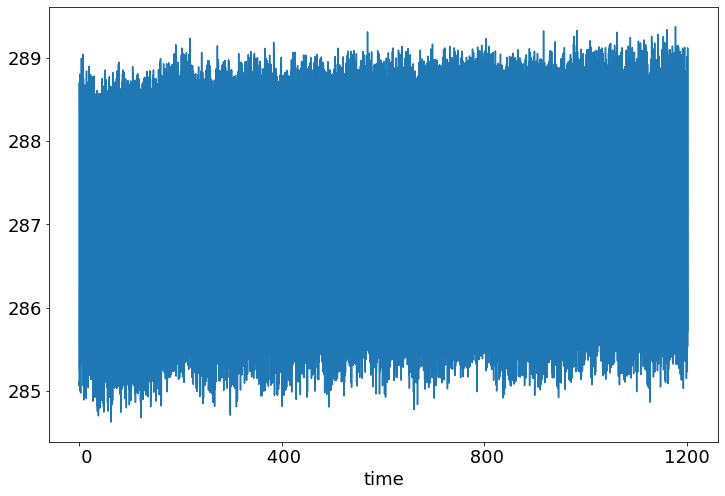

In [6]:
tmean.plot.line(x='time')

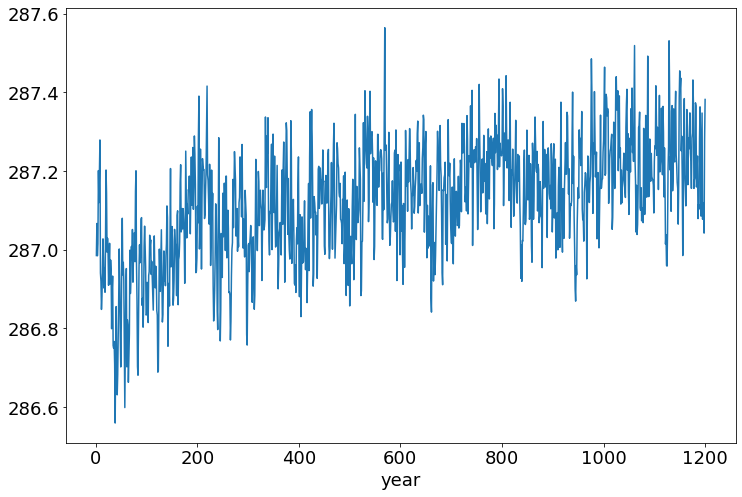

In [7]:
tmean.groupby('time.year').mean('time').plot.line(x='year')